# XGBoost (No Rolling Window)

## Preprocessing

- Implement Log returns calculation
- Normalize or scale key features
- Encode log return to binary value (one-hot encoding)

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)

df = pd.read_csv("../filtered_stocks_combined.csv")

# Change Date to DateTime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ticker', 'Date'])

# Create target variable
# 1 if current close > prev close, else 0
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close'])

df.head()

Date  index    Open    High     Low   Close     Volume  OpenInt  \
1 2011-01-04  45726  42.579  42.579  42.023  42.426   86135637        0   
2 2011-01-05  45727  42.260  42.817  42.196  42.772   70669988        0   
3 2011-01-06  45728  42.902  42.932  42.632  42.739   83619699        0   
4 2011-01-07  45729  42.787  43.073  42.503  43.045   86506108        0   
5 2011-01-10  45730  43.393  43.956  43.179  43.855  124888228        0   

  ticker  prev_close  target  
1   AAPL      42.204       1  
2   AAPL      42.426       1  
3   AAPL      42.772       0  
4   AAPL      42.739       1  
5   AAPL      43.045       1

## Split into training/test set

In [39]:
features = ['Open', 'High', 'Low', 'Volume']
X = df[features]
y = df['target']
groups = df['ticker']

# Split off 80:20 for train:test
splitter = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df['ticker']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter Tuning (RandomizedSearchCV)

In [40]:
tuning_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',          
    device='cuda',    
    random_state=42,                      
    eval_metric='auc',
    n_jobs=1              
)

rs_params = {
    "learning_rate":    [0.01, 0.03, 0.05, 0.1, 0.2, 0.3],
    "max_depth":        [3, 4, 5, 6, 8, 10, 12],
    "min_child_weight": [1, 2, 3, 5, 7, 10],
    "gamma":            [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha":        [0, 0.001, 0.01, 0.1, 1],
    "reg_lambda":       [0.5, 1, 1.5, 2, 5],
}

random_search = RandomizedSearchCV(
    tuning_clf,
    param_distributions=rs_params,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=1,
    cv=5,
    verbose=3
)

random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=2, subsample=0.8;, score=0.591 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=2, subsample=0.8;, score=0.638 total time=   0.2s
[CV 3/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=2, subsample=0.8;, score=0.621 total time=   0.1s
[CV 4/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=2, subsample=0.8;, score=0.594 total time=   0.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, reg_alpha=1, reg_lambda=2, subsample=0.8;, score=0.635 total time=   0.1s
[CV 1/5] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=12,

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device='cuda',
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                                           num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12],
                                        'min_child_weight': [1, 2, 3, 5, 7, 10],
                                        'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
                                        'reg_lambda': [0.5, 1, 1.5, 2, 5],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   scoring='roc_auc', verbose=3)

In [41]:
random_search.best_estimator_
random_search.best_params_

{'subsample': 0.8,
 'reg_lambda': 5,
 'reg_alpha': 1,
 'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

## Hyperparameter Tuning (GridSearchCV)

In [43]:
best_rs_params = random_search.best_params_

gs_params = {
    "learning_rate": [
        max(0.01, best_rs_params["learning_rate"] * 0.5),
        best_rs_params["learning_rate"],
        min(0.3,  best_rs_params["learning_rate"] * 1.5)
    ],

    "max_depth": sorted(list(set([
        max(1, best_rs_params["max_depth"] - 1),
        best_rs_params["max_depth"],
        best_rs_params["max_depth"] + 1
    ]))),

    "min_child_weight": sorted(list(set([
        max(1, best_rs_params["min_child_weight"] - 1),
        best_rs_params["min_child_weight"],
        best_rs_params["min_child_weight"] + 1
    ]))),

    "gamma": [
        max(0.0, best_rs_params["gamma"] - 0.1),
        best_rs_params["gamma"],
        best_rs_params["gamma"] + 0.1
    ],

    "subsample": [
        max(0.5, best_rs_params["subsample"] - 0.1),
        best_rs_params["subsample"],
        min(1.0, best_rs_params["subsample"] + 0.1)
    ],
    "colsample_bytree": [
        max(0.5, best_rs_params["colsample_bytree"] - 0.1),
        best_rs_params["colsample_bytree"],
        min(1.0, best_rs_params["colsample_bytree"] + 0.1)
    ],

    "reg_alpha": [
        max(0.0, best_rs_params["reg_alpha"] / 2),
        best_rs_params["reg_alpha"],
        best_rs_params["reg_alpha"] * 2
    ],
    "reg_lambda": [
        max(0.1, best_rs_params["reg_lambda"] / 2),
        best_rs_params["reg_lambda"],
        best_rs_params["reg_lambda"] * 2
    ]
}

grid_search = GridSearchCV(
    tuning_clf,
    param_grid=gs_params,
    scoring='roc_auc',
    n_jobs=1,
    cv=5,
    verbose=3
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6561 candidates, totalling 32805 fits
[CV 1/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=2, reg_alpha=0.5, reg_lambda=2.5, subsample=0.7000000000000001;, score=0.624 total time=   0.8s
[CV 2/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=2, reg_alpha=0.5, reg_lambda=2.5, subsample=0.7000000000000001;, score=0.673 total time=   0.6s
[CV 3/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=2, reg_alpha=0.5, reg_lambda=2.5, subsample=0.7000000000000001;, score=0.660 total time=   0.5s
[CV 4/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=2, reg_alpha=0.5, reg_lambda=2.5, subsample=0.7000000000000001;, score=0.622 total time=   0.5s
[CV 5/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.1, max_depth=11, min_child_weight=2, reg_alpha=0.5, reg_lambda=2.5, subsample=0.7000000000000001;, score

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=1, num_parallel_tree=None, ...),
             n_jobs=1,
             param_grid={'colsample_bytree': [0.9, 1.0, 1.0],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [11, 12, 13],
                         'min_child_weight': [2, 3, 4],
                         'reg_alpha': [0.5, 1, 2], 'reg_lambda': [2.5, 5, 10],
                         'subsample': [0.7000000000000001, 0.8, 0.9]},
             scoring='roc_auc', verbose=3)

In [44]:
grid_search.best_estimator_
grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.2,
 'learning_rate': 0.3,
 'max_depth': 13,
 'min_child_weight': 3,
 'reg_alpha': 2,
 'reg_lambda': 5,
 'subsample': 0.9}

## Final Fit

Test Accuracy:  0.6471
Test F1 Score:  0.6763
Test ROC AUC:   0.7159
Confusion Matrix:
[[4202 3128]
 [2197 5563]]


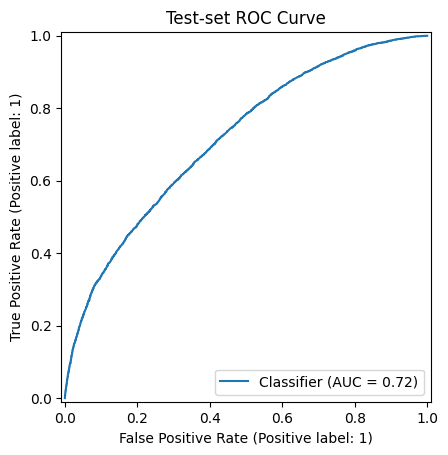

In [45]:
best_model = grid_search.best_estimator_

y_pred   = best_model.predict(X_test_scaled)
y_proba  = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute metrics
acc      = accuracy_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_proba)
cm       = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test F1 Score:  {f1:.4f}")
print(f"Test ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

# 5) (Optional) Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Test‑set ROC Curve")
plt.show()